In [14]:
%cd /content/drive/MyDrive/computer_vision/final

/content/drive/MyDrive/computer_vision/final


https://github.com/LukeDitria/CNN-VAE/blob/master/VAE.ipynb

In [15]:
!git clone https://github.com/LukeDitria/CNN-VAE.git

Cloning into 'CNN-VAE'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 85 (delta 5), reused 2 (delta 2), pack-reused 78
Unpacking objects: 100% (85/85), done.


In [16]:
%cd CNN-VAE

/content/drive/MyDrive/computer_vision/final/CNN-VAE


In [17]:
!pwd

/content/drive/MyDrive/computer_vision/final/CNN-VAE


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils
from torch.hub import load_state_dict_from_url

import os
import random
import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange, tqdm

from RES_VAE import VAE as VAE
from vgg19 import VGG19

In [42]:
batch_size = 128
image_size = 64
lr = 1e-4
nepoch = 100
start_epoch = 0
dataset_root = "../Documents/"
save_dir = os.getcwd()
model_name = "STL10_8" #"STL10_8" #STL10_8_64.pt
load_checkpoint  = True
use_cuda = torch.cuda.is_available()
GPU_indx  = 0
device = torch.device(GPU_indx if use_cuda else "cpu")

In [7]:
!ls ../Documents/

ls: cannot access '../Documents/': No such file or directory


In [20]:
def get_data_STL10(transform, batch_size, download = True, root = "/data"):
    print("Loading trainset...")
    trainset = Datasets.STL10(root=root, split='unlabeled', transform=transform, download=download)
    
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    print("Loading testset...")
    testset = Datasets.STL10(root=root, split='test', download=download, transform=transform)

    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    print("Done!")

    return trainloader, testloader

In [21]:
#OLD way of getting features and calculating loss - Not used

#create an empty layer that will simply record the feature map passed to it.
class GetFeatures(nn.Module):
    def __init__(self):
        super(GetFeatures, self).__init__()
        self.features = None
    def forward(self, x):
        self.features = x
        return x

#download the pre-trained weights of the VGG-19 and append them to an array of layers .
#we insert a GetFeatures layer after a relu layer.
#layers_deep controls how deep we go into the network
def get_feature_extractor(layers_deep = 7):
    C_net = models.vgg19(pretrained=True).to(device)
    C_net = C_net.eval()
    
    layers = []
    for i in range(layers_deep):
        layers.append(C_net.features[i])
        if isinstance(C_net.features[i], nn.ReLU):
            layers.append(GetFeatures())
    return nn.Sequential(*layers)

#this function calculates the L2 loss (MSE) on the feature maps copied by the layers_deep
#between the reconstructed image and the origional
def feature_loss(img, recon_data, feature_extractor):
    img_cat = torch.cat((img, torch.sigmoid(recon_data)), 0)
    out = feature_extractor(img_cat)
    loss = 0
    for i in range(len(feature_extractor)):
        if isinstance(feature_extractor[i], GetFeatures):
            loss += (feature_extractor[i].features[:(img.shape[0])] - feature_extractor[i].features[(img.shape[0]):]).pow(2).mean()
    return loss/(i+1)

In [22]:
#Linear scaling the learning rate down
def lr_Linear(epoch_max, epoch, lr):
    lr_adj = ((epoch_max-epoch)/epoch_max)*lr
    set_lr(lr = lr_adj)

def set_lr(lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def vae_loss(recon, x, mu, logvar):
    recon_loss = F.binary_cross_entropy_with_logits(recon, x)
    KL_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
    loss = recon_loss + 0.01 * KL_loss
    return loss

In [23]:
transform = T.Compose([T.Resize(image_size), T.ToTensor()])

trainloader, testloader = get_data_STL10(transform, batch_size, download=True, root=dataset_root)

Loading trainset...


  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ../Documents/stl10_binary.tar.gz to ../Documents/
Loading testset...
Files already downloaded and verified
Done!


In [24]:
#get a test image batch from the testloader to visualise the reconstruction quality
dataiter = iter(testloader)
test_images, _ = dataiter.next()
test_images.shape

torch.Size([128, 3, 64, 64])

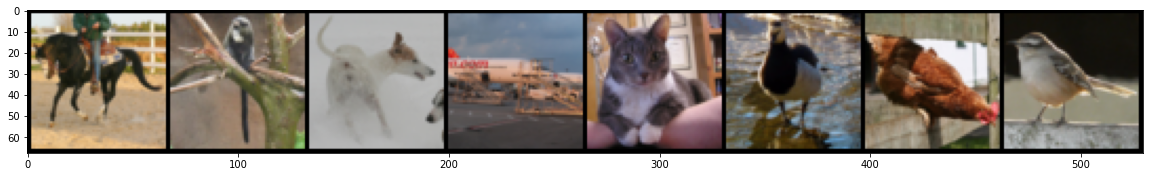

In [25]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8])
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [26]:
#Create the feature loss module

# load the state dict for vgg19
state_dict = torch.hub.load_state_dict_from_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth')
# manually create the feature extractor from vgg19
feature_extractor = VGG19(channel_in=3)

# loop through the loaded state dict and our vgg19 features net,
# loop will stop when net.parameters() runs out - so we never get to the "classifier" part of vgg
for ((name, source_param), target_param) in zip(state_dict.items(), feature_extractor.parameters()):
    target_param.data = source_param.data
    target_param.requires_grad = False
    
feature_extractor = feature_extractor.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [27]:
#Create VAE network
vae_net = VAE(channel_in=3, ch=64).to(device)
# setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr, betas=(0.5, 0.999))
#Loss function
BCE_Loss = nn.BCEWithLogitsLoss()
loss_log = []

In [43]:
#Create the save directory if it does note exist
if not os.path.isdir(save_dir + "/Models"):
    os.makedirs(save_dir + "/Models")
if not os.path.isdir(save_dir + "/Results"):
    os.makedirs(save_dir + "/Results")

if load_checkpoint:
    checkpoint = torch.load(save_dir + "/Models/" + model_name + "_" + str(image_size) + ".pt", map_location = "cpu")
    print("Checkpoint loaded")
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    vae_net.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint["epoch"]
    loss_log = checkpoint["loss_log"]
else:
    #If checkpoint does exist raise an error to prevent accidental overwriting
    if os.path.isfile(save_dir + "/Models/" + model_name + "_" + str(image_size) + ".pt"):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")

Checkpoint loaded


In [53]:
for epoch in trange(start_epoch, nepoch, leave=False):
    lr_Linear(nepoch, epoch, lr)
    vae_net.train()
    for i, (images, _) in enumerate(tqdm(trainloader, leave=False)):

        recon_data, mu, logvar = vae_net(images.to(device))
        #VAE loss
        loss = vae_loss(recon_data, images.to(device), mu, logvar)        
        
        #Perception loss
        loss += feature_extractor(torch.cat((torch.sigmoid(recon_data), images.to(device)), 0))
    
        loss_log.append(loss.item())
        vae_net.zero_grad()
        loss.backward()
        optimizer.step()

    #In eval mode the model will use mu as the encoding instead of sampling from the distribution
    print("epoch", epoch)
    vae_net.eval()
    with torch.no_grad():
        recon_data, _, _ = vae_net(test_images.to(device))
        recon_data, _, _ = vae_net(test_images.to(device))
        images = torch.cat((torch.sigmoid(recon_data.cpu()), test_images),2)
        save_path = "%s/%s/%s_%d_%d.png" % (save_dir, "Results" , model_name, image_size, epoch)
        print(images.shape) #[128, 3, 128, 64]
        print("save image at", save_path)
        vutils.save_image(images, save_path)

        #Save a checkpoint
        torch.save({
                    'epoch'                         : epoch,
                    'loss_log'                      : loss_log,
                    'model_state_dict'              : vae_net.state_dict(),
                    'optimizer_state_dict'          : optimizer.state_dict()

                     }, save_dir + "/Models/" + model_name + "_" + str(image_size) + ".pt")  

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

epoch 2
torch.Size([128, 3, 128, 64])
save image at /content/drive/MyDrive/computer_vision/final/CNN-VAE/Results/STL10_8_64_2.png


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 3
torch.Size([128, 3, 128, 64])
save image at /content/drive/MyDrive/computer_vision/final/CNN-VAE/Results/STL10_8_64_3.png


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 4
torch.Size([128, 3, 128, 64])
save image at /content/drive/MyDrive/computer_vision/final/CNN-VAE/Results/STL10_8_64_4.png


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 5
torch.Size([128, 3, 128, 64])
save image at /content/drive/MyDrive/computer_vision/final/CNN-VAE/Results/STL10_8_64_5.png


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 6
torch.Size([128, 3, 128, 64])
save image at /content/drive/MyDrive/computer_vision/final/CNN-VAE/Results/STL10_8_64_6.png


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 7
torch.Size([128, 3, 128, 64])
save image at /content/drive/MyDrive/computer_vision/final/CNN-VAE/Results/STL10_8_64_7.png


  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [54]:
#In eval mode the model will use mu as the encoding instead of sampling from the distribution
vae_net.eval()
with torch.no_grad():
    recon_data, _, _ = vae_net(test_images.to(device))
    images = torch.cat((torch.sigmoid(recon_data.cpu()), test_images),2)
    save_path = "%s/%s/%s_%d.png" % (save_dir, "Results" , model_name, image_size)
    print(images.shape) #[128, 3, 128, 64]
    print("save image at", save_path)
    vutils.save_image(images, save_path)
    


torch.Size([128, 3, 128, 64])
save image at /content/drive/MyDrive/computer_vision/final/CNN-VAE/Results/STL10_8_64.png


In [33]:
%cd /content/drive/MyDrive/computer_vision/final/CNN-VAE/Results

/content/drive/MyDrive/computer_vision/final/CNN-VAE/Results


In [35]:
%cd ..

/content/drive/MyDrive/computer_vision/final/CNN-VAE


In [41]:
!ls /content/drive/MyDrive/computer_vision/final/CNN-VAE/Models

STL10_8_64.pt


In [36]:
!ls /content/drive/MyDrive/computer_vision/final/CNN-VAE/Results

STL10_8_64.png			       VAE.gif
VAE_celeba_64.png		       VAE_STL10_64.png
VAE_CelebA_all_Feat_new_model_128.png  VAE_STL10_no_perception_64.png


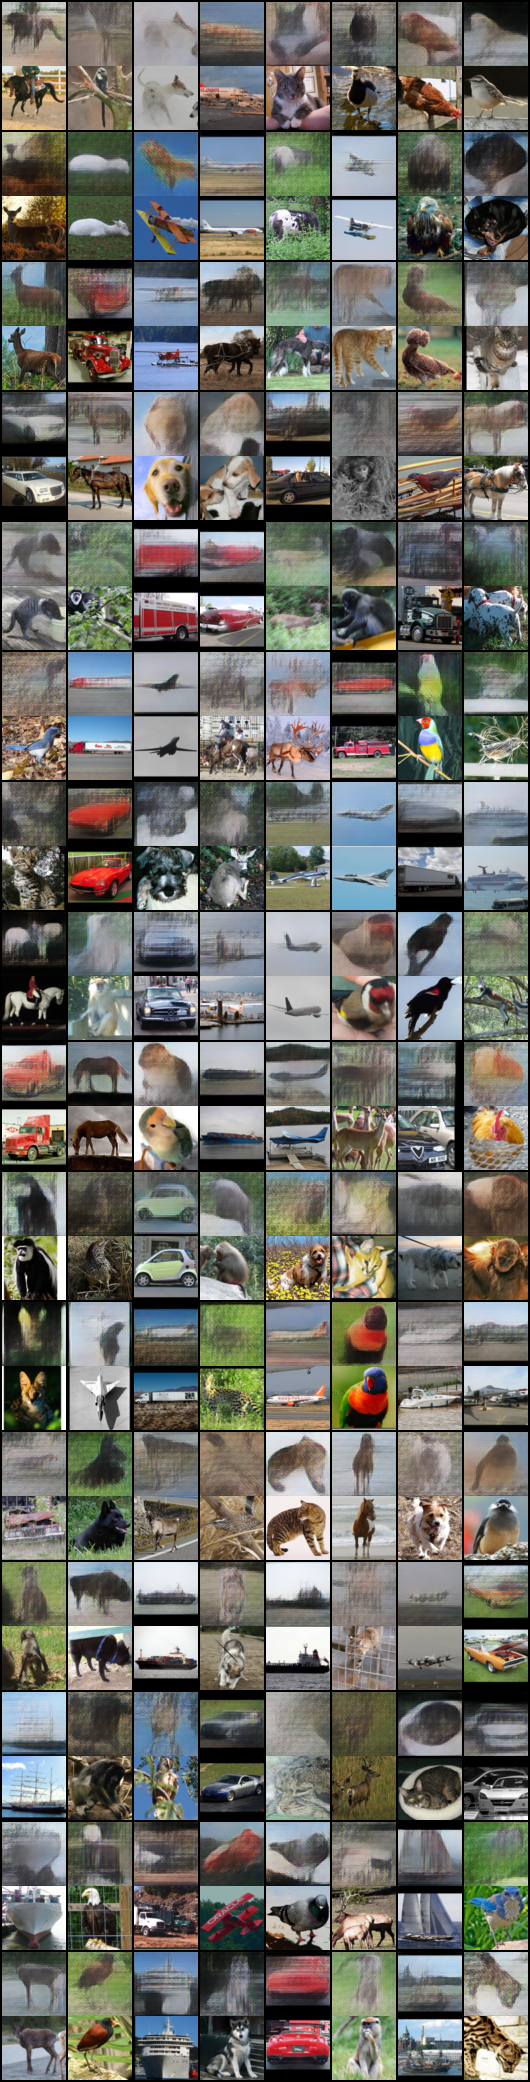

In [55]:
from PIL import Image
#/content/drive/MyDrive/computer_vision/final/CNN-VAE/Results/STL10_8_64.png
path = "/content/drive/MyDrive/computer_vision/final/CNN-VAE/Results/" + "STL10_8_64.png"
#path = "/content/drive/MyDrive/computer_vision/final/CNN-VAE/Results/" + "VAE_STL10_64.png"
img = Image.open(path)
display(img)